### Imports

In [145]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean, cityblock, cosine
from scipy.stats import pearsonr
import pickle

from src.utils.ml_metrics import mapk

### Constants

In [128]:
query_folder = "./data/qsd1_w3/non_augmented/"
bbdd_folder = "./data/BBDD"

### Helper functions

In [129]:
def plot_image(image):
    if len(image.shape)==2:
        plt.imshow(image, cmap="gray")
    else:
        plt.imshow(image)
    plt.axis('off')
    plt.show()

### Plots

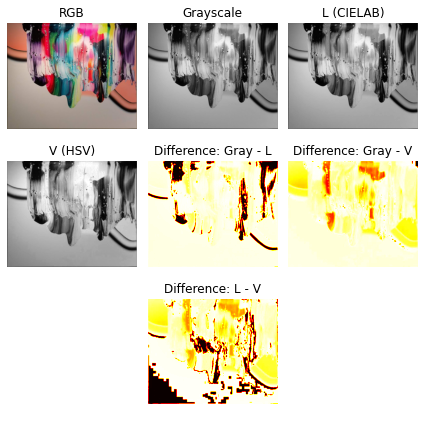

In [130]:
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

def plot_image_variants(image_path):
    # Load the image using PIL (RGB format)
    img_rgb = Image.open(image_path)
    img_rgb = np.array(img_rgb)  # Convert to NumPy array

    # Convert to grayscale using OpenCV
    img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)

    # Convert to CIELAB and extract L channel
    img_lab = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2LAB)
    L_channel = img_lab[:, :, 0]  # L channel (lightness)

    # Convert to HSV and extract V (value) channel
    img_hsv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)
    V_channel = img_hsv[:, :, 2]  # V channel (value)

    # Compute differences
    diff_gray_L = np.abs(img_gray - L_channel)
    diff_gray_V = np.abs(img_gray - V_channel)
    diff_L_V = np.abs(L_channel - V_channel)

    # Plot all images and their differences
    fig, axes = plt.subplots(3, 3, figsize=(6, 6))

    # RGB image
    axes[0, 0].imshow(img_rgb)
    axes[0, 0].set_title("RGB")
    axes[0, 0].axis("off")

    # Grayscale image
    axes[0, 1].imshow(img_gray, cmap="gray")
    axes[0, 1].set_title("Grayscale")
    axes[0, 1].axis("off")

    # L channel from CIELAB
    axes[0, 2].imshow(L_channel, cmap="gray")
    axes[0, 2].set_title("L (CIELAB)")
    axes[0, 2].axis("off")

    # V channel from HSV
    axes[1, 0].imshow(V_channel, cmap="gray")
    axes[1, 0].set_title("V (HSV)")
    axes[1, 0].axis("off")

    # Difference between Gray and L
    axes[1, 1].imshow(diff_gray_L, cmap="hot")
    axes[1, 1].set_title("Difference: Gray - L")
    axes[1, 1].axis("off")

    # Difference between Gray and V
    axes[1, 2].imshow(diff_gray_V, cmap="hot")
    axes[1, 2].set_title("Difference: Gray - V")
    axes[1, 2].axis("off")

    # Difference between L and V
    axes[2, 1].imshow(diff_L_V, cmap="hot")
    axes[2, 1].set_title("Difference: L - V")
    axes[2, 1].axis("off")

    # Hide empty plot
    axes[2, 0].axis("off")
    axes[2, 2].axis("off")

    # Show the plots
    plt.tight_layout()
    plt.show()

# Example usage
image_path = os.path.join(query_folder, "00000.jpg")
plot_image_variants(image_path)

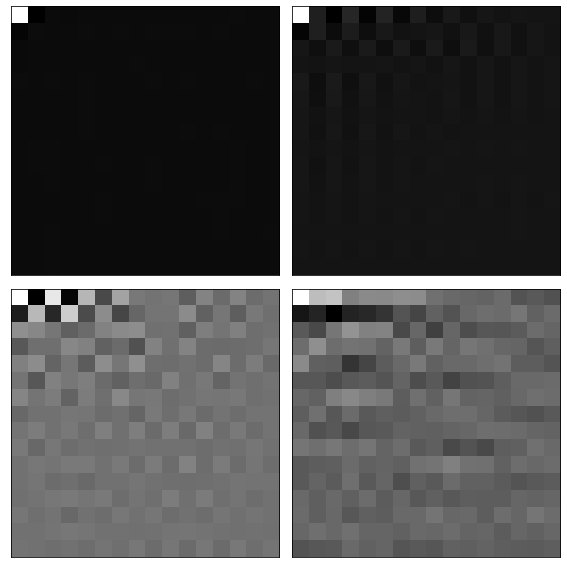

In [131]:
def plot_images_in_grid(images, figsize=(6, 6)):
    """
    Plots a list of images in a square grid format.
    Assumes the list length is one of the following: 1, 4, 16, 64, 256, or 1024.
    
    Parameters:
    images (list of numpy arrays): List of images to be plotted. Each image is assumed to be in greyscale.
    """
    # Find the square root of the number of images to determine the grid size
    grid_size = int(np.sqrt(len(images)))
    
    # Create a matplotlib figure
    fig, axes = plt.subplots(grid_size, grid_size, figsize=figsize)
    
    # Loop through each image and plot it
    for i, ax in enumerate(axes.flat):
        # Show the image in greyscale
        ax.imshow(images[i], cmap='gray', aspect='equal')
        
        # Remove axis ticks
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Adjust spacing between plots
    plt.tight_layout()
    plt.show()

image_path = os.path.join(query_folder, "00000.jpg")
image = cv2.imread(image_path)
image = preprocess_image(image, image_size=(256, 256))
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

block_size=16
image_float32 = np.float32(image)
height, width = image.shape
dct_blocks = []
# Iterate over the image in block-sized steps
for i in range(0, height, block_size):
    for j in range(0, width, block_size):
        # Extract the block
        block = image_float32[i:i + block_size, j:j + block_size]
        # Compute the DCT for the block
        dct_block = cv2.dct(block)
        # Append the DCT of the block to the list for this image
        dct_blocks.append(dct_block)

plot_images_in_grid(dct_blocks[0:4], figsize=(8,8))

### Main functions

In [132]:
def load_and_preprocess_images(folder, extension=".jpg"):
    images = []
    for filename in os.listdir(folder):
        if filename.endswith((extension)):
            image_path = os.path.join(folder, filename)
            # Read image
            image = cv2.imread(image_path)
            # Check if the image was loaded successfully
            if image is not None:
                image = preprocess_image(image, image_size=(256, 256))
                images.append(image)
            else:
                print(f"Failed to load image: {image_path}")
    return images

In [133]:
def preprocess_image(image, image_size=(256, 256)):
    # Resize image
    image = cv2.resize(image, image_size)
    
    return image

In [134]:
def transform_images_color_space(images, color_space="gray"):
    """
    Transforms the color space of the given images.

    Args:
    - images (list): List of loaded images (in BGR format).
    - color_space (str): The target color space.
                        "gray" - Grayscale,
                        "L"    - L channel of CIELAB,
                        "V"    - V channel of HSV.
    
    Returns:
    - transformed_images (list): List of processed images in the target color space.
    """

    transformed_images = []

    for img in images:
        if color_space == "gray":
            # Convert the image to grayscale
            gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            transformed_images.append(gray_img)

        elif color_space == "L":
            # Convert the image to CIELAB and extract the L channel
            lab_img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
            L_channel = lab_img[:, :, 0]  # Extract the L channel
            transformed_images.append(L_channel)

        elif color_space == "V":
            # Convert the image to HSV and extract the V channel
            hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
            V_channel = hsv_img[:, :, 2]  # Extract the V channel
            transformed_images.append(V_channel)

        else:
            raise ValueError("Invalid color_space argument. Choose 'gray', 'L', or 'V'.")

    return transformed_images

In [135]:
def compute_images_block_dct(images, block_size=8):
    """
    Given a list of images, computes the Discrete Cosine Transform (DCT) for each image by blocks.

    Args:
    - images (list): List of images.
    - block_size (int): The size of the blocks for which the DCT will be computed.

    Returns:
    - block_dct_images (list): A list of lists of DCTs for each image, where each image's DCT is divided into blocks.
    """

    block_dct_images = []

    for img in images:
        img_float32 = np.float32(img)  # Convert image to float32 for DCT calculation
        height, width = img.shape
        dct_blocks = []

        # Iterate over the image in block-sized steps
        for i in range(0, height, block_size):
            for j in range(0, width, block_size):
                # Extract the block
                block = img_float32[i:i + block_size, j:j + block_size]

                # Compute the DCT for the block
                dct_block = cv2.dct(block)

                # Append the DCT of the block to the list for this image
                dct_blocks.append(dct_block)

        # Append the list of DCT blocks for this image to the final result
        block_dct_images.append(dct_blocks)

    return block_dct_images

In [167]:
def zigzag_indices(N):
    """
    Generates the zigzag order indices for an NxN block.
    
    Args:
    - block_size (int): The size of the DCT block (e.g., 8 for an 8x8 block).
    
    Returns:
    - zigzag (list): Indices indicating the zigzag order of the block.
    """
    indices = []
    for k in range(2 * N - 1):
        if k % 2 == 0:
            i_start = min(k, N - 1)
            i_end = max(0, k - N + 1)
            for i in range(i_start, i_end - 1, -1):
                j = k - i
                indices.append(i * N + j)
        else:
            i_start = max(0, k - N + 1)
            i_end = min(k, N - 1)
            for i in range(i_start, i_end + 1):
                j = k - i
                indices.append(i * N + j)
    return indices

def extract_dct_coefficients_zigzag(block_dct_images, num_coefs, block_size=8):
    """
    Extracts the first num_coefs coefficients in zigzag order from each block DCT for each image, and concatenates 
    these coefficients into a single vector per image.

    Args:
    - block_dct_images (list of lists): List of images, where each 
                                        image is a list of DCT blocks.
    - num_coefs (int): The number of DCT coefficients to extract from each block in zigzag order.
    - block_size (int): The size of the blocks used in DCT.

    Returns:
    - dct_vectors (list of lists): A list of vectors, each representing the concatenation 
                                   of the first K coefficients from each DCT block for each image.
    """

    # Get the zigzag indices for an 8x8 block
    zigzag = zigzag_indices(block_size)
    
    dct_vectors = []

    for blocks in block_dct_images:
        image_vector = []

        for block_dct in blocks:
            # Extract the coefficients in zigzag order
            zigzag_coeffs = zigzag_indices(block_size)
            flattened_block = block_dct.flatten()
            reordered_block_dct = flattened_block[zigzag_coeffs]
            first_coefs = reordered_block_dct[:num_coefs]

            # Append the num_coefs zigzag coefficients to the image vector
            image_vector.extend(first_coefs)

        # Append the concatenated vector for this image to the final list
        dct_vectors.append(image_vector)

    return dct_vectors

In [168]:
def compare_vectors(vec1, vec2, method="L2"):
    """
    Compares two vectors using the specified method and returns the distance or similarity.
    
    Args:
    - vec1 (list or array): The first vector.
    - vec2 (list or array): The second vector.
    - method (str): The method to use for comparison. Options are:
        - "L1" for Manhattan distance (city block distance)
        - "L2" for Euclidean distance
        - "Cosine" for Cosine similarity
        - "Pearson" for Pearson correlation
    
    Returns:
    - result (float): The computed distance or similarity.
    """
    
    if method == "L1":
        # Manhattan distance (L1)
        result = cityblock(vec1, vec2)
    
    elif method == "L2":
        # Euclidean distance (L2)
        result = euclidean(vec1, vec2)
    
    elif method == "Cosine":
        # Cosine distance
        result = cosine(vec1, vec2)
    
    elif method == "Pearson":
        # Pearson correlation
        result, _ = pearsonr(vec1, vec2)
    
    else:
        raise ValueError("Unsupported method.")
    
    return result

In [173]:
def create_distance_matrix_vectors(query_vectors, bbdd_vectors, method):
    """
    Computes the similarity between a list of query vectors and a list 
    of database vectors.

    Parameters
    ----------
    query_hists : list
        List of all the query vectors.
    bbdd_hists : list
        List that contains the vectors of the DB.
    method : str
        Specifies which similarity method to use.
        Methods available:
        - "L1" for Manhattan distance (city block distance)
        - "L2" for Euclidean distance
        - "Cosine" for Cosine similarity
        - "Pearson" for Pearson correlation

    Returns
    -------
    similarity_matrix: ndarray
        Matrix with all the similarity values.
    """
    # A row for each query and a column for each element in the DB to search
    similarity_matrix = np.zeros((len(query_vectors), len(bbdd_vectors)))

    for ii, query in enumerate(query_vectors):
        for jj, bd in enumerate(bbdd_vectors):
            similarity_matrix[ii][jj] = compare_vectors(query, bd, method)

    return similarity_matrix

In [174]:
def generate_results(similarity_matrix, distance_measure):
    """
    Generates a matrix that contains the indexes of each image sorted by score
    for each row.

    Parameters
    ----------
    similarity_matrix: ndarray
        Matrix with all the similarity values
    
    distance_measre: str
        The distance measure used to generate the similarity matrix
        Methods available according to OpenCV:
        'correlation': cv2.HISTCMP_CORREL,
        'chi-square': cv2.HISTCMP_CHISQR,
        'intersection': cv2.HISTCMP_INTERSECT,
        'bhattacharyya': cv2.HISTCMP_BHATTACHARYYA,
        'hellinger': cv2.HISTCMP_HELLINGER,
        'kl-divergence': cv2.HISTCMP_KL_DIV
        - "L1" for Manhattan distance (city block distance) (for vectors)
        - "L2" for Euclidean distance (for vectors)
        - "Cosine" for Cosine similarity (for vectors)
        'Pearson': Parson correlation (for vectors)
    
    Returns
    -------
    result: list
        A list containing sorted lists of indexes by score of the similarity matrix.
    """
    result = []
    if distance_measure in ["correlation", "intersection", "Pearson"]:
        for row in similarity_matrix:
            result.append(np.argsort(row)[::-1])
    else:
        for row in similarity_matrix:
            result.append(np.argsort(row))
    return result

In [187]:
def dct_study(query_folder, bbdd_folder, 
              colors = ["gray", "L", "V"], 
              block_sizes = [256, 128, 64, 32, 16, 8],
              num_coefs_list = [64, 32, 16, 8, 4],
              distance_measures = ["L1", "L2", "Cosine", "Pearson"]):
    
    # Store results in a list that will later be converted to a dataframe
    full_results = []
    
    # Load and preprocess query images
    query_images = load_and_preprocess_images(query_folder, extension=".jpg")

    # Load and preprocess bbdd images
    bbdd_images = load_and_preprocess_images(bbdd_folder, extension=".jpg")
    
    for color in colors:
        
        # Load groundtruth
        gt_dir = os.path.join(query_folder, 'gt_corresps.pkl')
        with open(gt_dir, 'rb') as reader:
            ground_truth = pickle.load(reader)
        
        # Transform the color space of the query images
        query_images_color = transform_images_color_space(query_images, color_space=color)
        
        # Transform the color space of the bbdd images
        bbdd_images_color = transform_images_color_space(bbdd_images, color_space=color)
        
        for block_size in block_sizes:
            
            # Compute the DCT of the query images
            query_dct_blocks = compute_images_block_dct(query_images_color, block_size)
            
            # Compute the DCT of the bbdd images
            bbdd_dct_blocks = compute_images_block_dct(bbdd_images_color, block_size)
            
            for num_coefs in num_coefs_list:
                
                # Extract first K coefficients of query images DCTs
                query_feature_vectors = extract_dct_coefficients_zigzag(query_dct_blocks, num_coefs, block_size)
                
                # Extract first K coefficients of bbdd images DCTs
                bbdd_feature_vectors = extract_dct_coefficients_zigzag(bbdd_dct_blocks, num_coefs, block_size)
                
                for distance_measure in distance_measures:
                    
                    # Print current combination
                    print(f"{color}, {block_size} block size, {num_coefs} coefs, {distance_measure}", end=" ")
                    
                    # Calculate distance matrix
                    distance_matrix = create_distance_matrix_vectors(query_feature_vectors, 
                                                                     bbdd_feature_vectors,
                                                                     distance_measure)
                    # Generate sorted results
                    results = generate_results(distance_matrix, distance_measure)
                    
                    # Calculate metrics
                    mapk_val_1 = mapk(ground_truth, results, 1)
                    mapk_val_5 = mapk(ground_truth, results, 5)
                    
                    # Print metrics for current combination
                    print(f"-- MAPK@{1}: {mapk_val_1} -- MAPK@{5}: {mapk_val_5}")
                    
                    # Save current combination parameters and results
                    combination_results = {}
                    combination_results['Color'] = color
                    combination_results['Block size'] = block_size
                    combination_results['Num. coeffs'] = num_coefs
                    combination_results['Distance measure'] = distance_measure
                    combination_results['Feature vec. dim.'] = num_coefs*((256/block_size)**2)
                    combination_results['MAP@1'] = mapk_val_1
                    combination_results['MAP@5'] = mapk_val_5
                    full_results.append(combination_results)
                    
    # Save results to csv via df
    full_results_df = pd.DataFrame(full_results)
    full_results_df.to_csv("dct_study_results.csv")
    
    return full_results_df

In [189]:
dct_study(query_folder, bbdd_folder, 
              colors = ["gray", "L", "V"], 
              block_sizes = [256, 128, 64, 32, 16, 8],
              num_coefs_list = [64, 32, 16, 8, 4],
              distance_measures = ["L1", "L2", "Cosine", "Pearson"])

gray, 256 block size, 64 coefs, L1 -- MAPK@1: 0.9333333333333333 -- MAPK@5: 0.94
gray, 256 block size, 64 coefs, L2 -- MAPK@1: 0.7333333333333333 -- MAPK@5: 0.7733333333333333
gray, 256 block size, 64 coefs, Cosine -- MAPK@1: 0.9666666666666667 -- MAPK@5: 0.9666666666666667
gray, 256 block size, 64 coefs, Pearson -- MAPK@1: 0.9666666666666667 -- MAPK@5: 0.9666666666666667
gray, 256 block size, 32 coefs, L1 -- MAPK@1: 0.8666666666666667 -- MAPK@5: 0.9
gray, 256 block size, 32 coefs, L2 -- MAPK@1: 0.6666666666666666 -- MAPK@5: 0.7083333333333334
gray, 256 block size, 32 coefs, Cosine -- MAPK@1: 0.9666666666666667 -- MAPK@5: 0.9666666666666667
gray, 256 block size, 32 coefs, Pearson -- MAPK@1: 0.9666666666666667 -- MAPK@5: 0.9666666666666667
gray, 256 block size, 16 coefs, L1 -- MAPK@1: 0.7333333333333333 -- MAPK@5: 0.7722222222222223
gray, 256 block size, 16 coefs, L2 -- MAPK@1: 0.6333333333333333 -- MAPK@5: 0.6566666666666666
gray, 256 block size, 16 coefs, Cosine -- MAPK@1: 0.933333333

L, 32 block size, 16 coefs, Cosine -- MAPK@1: 1.0 -- MAPK@5: 1.0
L, 32 block size, 16 coefs, Pearson -- MAPK@1: 1.0 -- MAPK@5: 1.0
L, 32 block size, 8 coefs, L1 -- MAPK@1: 0.9 -- MAPK@5: 0.9
L, 32 block size, 8 coefs, L2 -- MAPK@1: 0.8333333333333334 -- MAPK@5: 0.8583333333333333
L, 32 block size, 8 coefs, Cosine -- MAPK@1: 0.9666666666666667 -- MAPK@5: 0.975
L, 32 block size, 8 coefs, Pearson -- MAPK@1: 0.9666666666666667 -- MAPK@5: 0.975
L, 32 block size, 4 coefs, L1 -- MAPK@1: 0.8666666666666667 -- MAPK@5: 0.8833333333333333
L, 32 block size, 4 coefs, L2 -- MAPK@1: 0.8333333333333334 -- MAPK@5: 0.8444444444444446
L, 32 block size, 4 coefs, Cosine -- MAPK@1: 0.9666666666666667 -- MAPK@5: 0.975
L, 32 block size, 4 coefs, Pearson -- MAPK@1: 0.9666666666666667 -- MAPK@5: 0.975
L, 16 block size, 64 coefs, L1 -- MAPK@1: 0.6 -- MAPK@5: 0.6622222222222222
L, 16 block size, 64 coefs, L2 -- MAPK@1: 0.8333333333333334 -- MAPK@5: 0.85
L, 16 block size, 64 coefs, Cosine -- MAPK@1: 0.933333333333

V, 64 block size, 16 coefs, L1 -- MAPK@1: 0.9333333333333333 -- MAPK@5: 0.9416666666666667
V, 64 block size, 16 coefs, L2 -- MAPK@1: 0.8666666666666667 -- MAPK@5: 0.8666666666666667
V, 64 block size, 16 coefs, Cosine -- MAPK@1: 0.9666666666666667 -- MAPK@5: 0.975
V, 64 block size, 16 coefs, Pearson -- MAPK@1: 0.9666666666666667 -- MAPK@5: 0.975
V, 64 block size, 8 coefs, L1 -- MAPK@1: 0.8666666666666667 -- MAPK@5: 0.8983333333333333
V, 64 block size, 8 coefs, L2 -- MAPK@1: 0.7666666666666667 -- MAPK@5: 0.8055555555555556
V, 64 block size, 8 coefs, Cosine -- MAPK@1: 0.9666666666666667 -- MAPK@5: 0.9666666666666667
V, 64 block size, 8 coefs, Pearson -- MAPK@1: 0.9666666666666667 -- MAPK@5: 0.9666666666666667
V, 64 block size, 4 coefs, L1 -- MAPK@1: 0.7666666666666667 -- MAPK@5: 0.8
V, 64 block size, 4 coefs, L2 -- MAPK@1: 0.7 -- MAPK@5: 0.75
V, 64 block size, 4 coefs, Cosine -- MAPK@1: 0.9333333333333333 -- MAPK@5: 0.95
V, 64 block size, 4 coefs, Pearson -- MAPK@1: 0.9333333333333333 -- 

,Color,Block size,Num. coeffs,Distance measure,Feature vec. dim.,MAP@1,MAP@5
0,gray,256,64,L1,64.0,0.933333,0.940000
1,gray,256,64,L2,64.0,0.733333,0.773333
2,gray,256,64,Cosine,64.0,0.966667,0.966667
3,gray,256,64,Pearson,64.0,0.966667,0.966667
4,gray,256,32,L1,32.0,0.866667,0.900000
...,...,...,...,...,...,...,...
355,V,8,8,Pearson,8192.0,0.966667,0.966667
356,V,8,4,L1,4096.0,0.833333,0.841667
357,V,8,4,L2,4096.0,0.833333,0.841667
358,V,8,4,Cosine,4096.0,0.966667,0.983333
